##   Imports & Definitions

In [10]:
# Load required libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import xgboost as xgb
import pickle
%matplotlib inline

## Load Data

In [11]:
path  = ""
train = pd.read_csv(path + "train.csv")
test  = pd.read_csv(path + "test.csv")

## Cleaning data

In [12]:
train['dataset'] = "train"
train = train.dropna(how='any', subset=['log_price'])

In [13]:
test['dataset'] = "test"
data = pd.concat([train,test], axis = 0)

/home/vero-apli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [14]:
data.head()

,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,dataset,...,log_price,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode
0,3,"{""Wireless Internet"",""Air conditioning"",Kitche...",1.0,Real Bed,1.0,1.0,strict,NYC,True,train,...,5.010635,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201
1,7,"{""Wireless Internet"",""Air conditioning"",Kitche...",1.0,Real Bed,3.0,3.0,strict,NYC,True,train,...,5.129899,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,Apartment,93.0,Entire home/apt,https://a0.muscache.com/im/pictures/348a55fe-4...,10019
2,5,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",1.0,Real Bed,1.0,3.0,moderate,NYC,True,train,...,4.976734,-73.943756,The Garden Oasis,Harlem,10,Apartment,92.0,Entire home/apt,https://a0.muscache.com/im/pictures/6fae5362-9...,10027
3,4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1.0,Real Bed,2.0,2.0,flexible,SF,True,train,...,6.620073,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,House,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,0.0,1.0,moderate,DC,True,train,...,4.744932,-77.034596,Great studio in midtown DC,Columbia Heights,4,Apartment,40.0,Entire home/apt,NaN,20009


In [15]:
data = data[[
    'id',
    'log_price', 
    'property_type', 
    'room_type',
    'accommodates',
    'bathrooms',
    'bed_type', 
    'cancellation_policy',
    'cleaning_fee',
    'city',
    'first_review',
    'host_has_profile_pic',
    'host_identity_verified',
    'host_response_rate',
    'instant_bookable', 
    'last_review', 
    'latitude',
    'longitude',
    'number_of_reviews',
    'review_scores_rating', 
    'bedrooms',
    'beds',
    'dataset']]

In [16]:
# drop inconsistent values
data = data[data['log_price'] != 0.00]

In [17]:
# convert date columns to datetime type
data.last_review  = pd.to_datetime(data.last_review)
data.first_review = pd.to_datetime(data.first_review)

In [18]:
data["review_days"] = (data.last_review - data.first_review).dt.days

In [19]:
data.drop(['last_review', 'first_review'], inplace = True, axis=1)

## Descriptive analysis

In [20]:
def plot_hist(n, titles, ranges):
    fig, ax = plt.subplots(n, figsize = (8, 7.5))
    for i in range(n):
        d, bins, patches = ax[i].hist(ranges[i], 50, normed = 1, color= BNB_RED, alpha = 0.85)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("log_price")
        ax[i].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

/home/vero-apli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/vero-apli/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/vero-apli/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


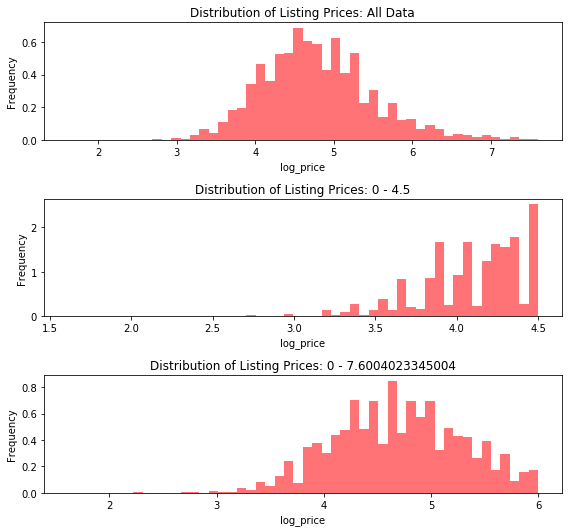

In [21]:
# Let's find out how the prices are distributed
BNB_RED   = '#FF5A5F'
prices    = data['log_price']
max_price = max(data.log_price)
min_price = min(data.log_price)
# Plot histograms of price distribution
plot_hist(3, ['Distribution of Listing Prices: All Data', 'Distribution of Listing Prices: 0 - 4.5', 
               'Distribution of Listing Prices: 0 - '+ str(max_price)], [prices, prices[prices <= 4.5], prices[prices < 6]])

The main log_price range is between 3 and 6.

In [22]:
# Group data, counting accommodates by city 
city_price = data.groupby("city").accommodates.sum()

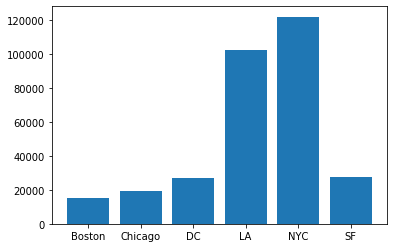

In [23]:
# Let's see the cities and their respective accommodations
height = city_price
bars   = city_price.index
y_pos  = np.arange(len(bars))
 
# Bars
plt.bar(y_pos, height)
 
# Names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()

The largest number of accommodations are in NYC and LA.

In [24]:
# Group data, counting accommodates by property_type 
city_property_type = data.groupby("property_type").accommodates.sum()

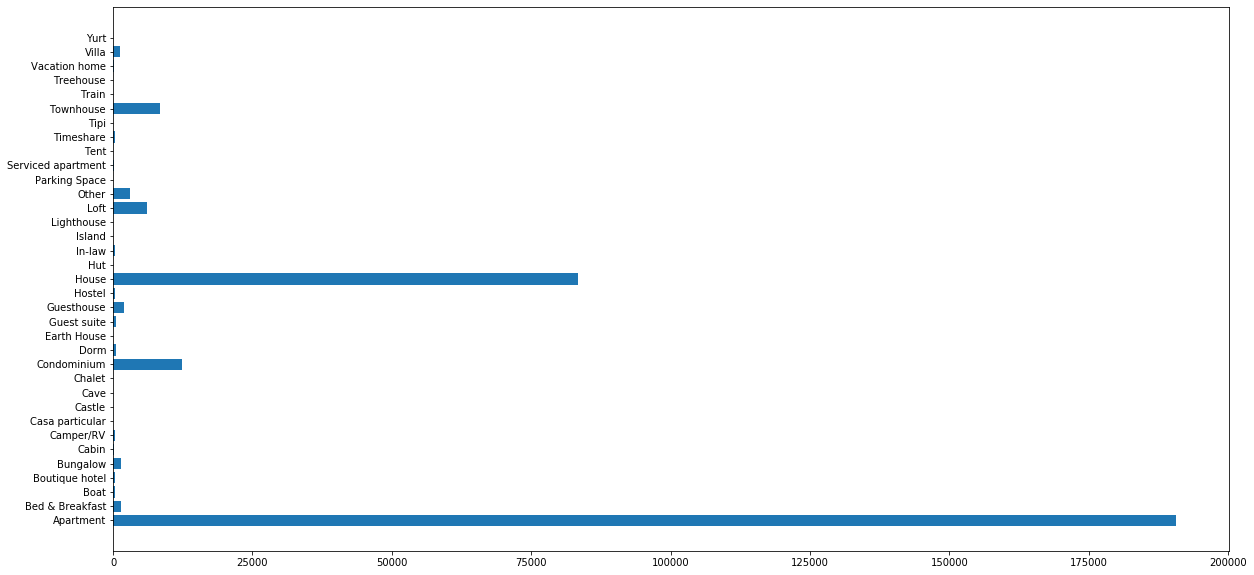

In [25]:
height = city_property_type
bars   = city_property_type.index
y_pos  = np.arange(len(bars))

plt.figure(figsize=(20,10))
# Bars
plt.barh(y_pos, height)
 
# Names on the y-axis
plt.yticks(y_pos, bars)

# Show graphic
plt.show()

/home/vero-apli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


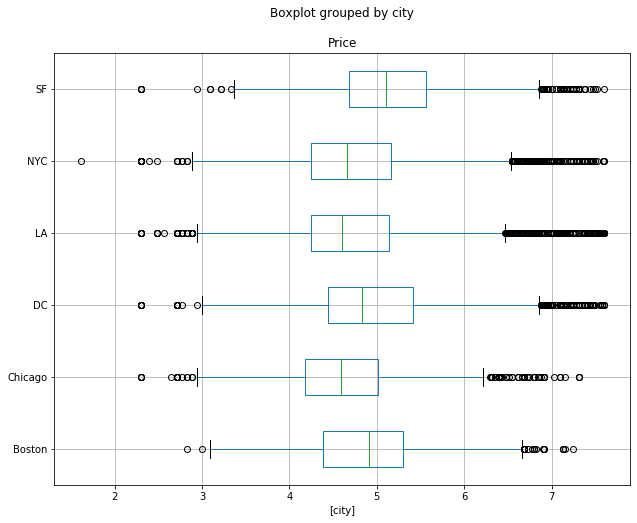

In [26]:
# Graph to know how the prices are distributed according to the city
city_price_df = data[['city','log_price']]
city_price_df['Price'] = (city_price_df['log_price'])
city_price_df[['city','Price']].boxplot(by = 'city', figsize=(10, 8), vert=False)

With the graphs made earlier we can see that there are some outliers in the data.

In [27]:
# Deleting outliers to make our prediction better
data = data[((data["log_price"] >= int(3)) & (data["log_price"] <= int(6)) ) | (data["dataset"] == "test")]

In [28]:
data.select_dtypes(include = numerics).columns

Index(['id', 'log_price', 'accommodates', 'bathrooms', 'latitude', 'longitude',
       'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds',
       'review_days'],
      dtype='object')

[Text(0.5, 0, 'bedrooms'),
 Text(1.5, 0, 'accommodates'),
 Text(2.5, 0, 'log_price'),
 Text(3.5, 0, 'beds'),
 Text(4.5, 0, 'bathrooms'),
 Text(5.5, 0, 'number_of_reviews'),
 Text(6.5, 0, 'review_scores_rating'),
 Text(7.5, 0, 'latitude'),
 Text(8.5, 0, 'longitude')]

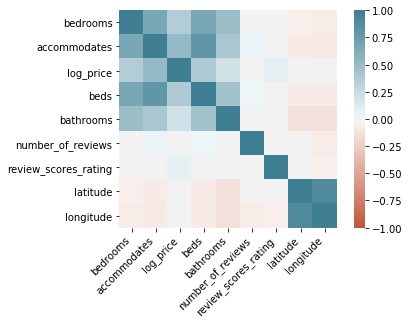

In [29]:
# Correlation between numerical variables
columns = ["bedrooms", "accommodates", 'log_price', "beds", "bathrooms", "number_of_reviews","review_scores_rating","latitude","longitude"] 
corr = data[columns].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
    

The number of are the variables accommodates, bedrooms, beds that are most related to the price.

## Data preparation

In [30]:
# One-hot-encode categorical variables
categorical = ['property_type','room_type','bed_type','cancellation_policy','city']
data        = pd.get_dummies(data, columns = categorical)

In [31]:
# Those variables have binary values which are represented by [t,f,True or False]
binary_columns = {
     'cleaning_fee',
     'host_has_profile_pic',
     'host_identity_verified',
     'instant_bookable'
 }

In [32]:
binary_map = {'t' : 1, 'f' : 0, True : 1, False : 0, np.nan : np.nan }

In [33]:
# mapping different binary representations with 0 and 1
for column in binary_columns:
    data[column] = data[column].map(binary_map)

In [34]:
# filling the empty data
data = data.fillna(0)

In [35]:
data['host_response_rate'].head(5)

0       0
1    100%
2    100%
4    100%
5    100%
Name: host_response_rate, dtype: object

In [36]:
# replacing "%" with "" and changing the data type to int 
data['host_response_rate'] = data['host_response_rate'].apply(lambda x: str(x).replace("%", "")).astype(int)

In [37]:
train_dataset = data[data.dataset == "train"].drop(["dataset", "id", "log_price"] ,axis = 1).select_dtypes(include=numerics).fillna(0)
test_dataset  = data[data.dataset == "test"].drop(["dataset", "id", "log_price"],axis = 1).select_dtypes(include=numerics).fillna(0)

## split train and test data

In [38]:
# Select only numeric data and impute missing values as 0
numerics = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train_x  = train_dataset.values
test_x = test_dataset.values
train_y = data[data.dataset == "train"].log_price.values

## Train and evaluation models

### RandomForestRegressor model with cross-validation

In [39]:
# Train a Random Forest model with cross-validation

cv_groups = KFold(n_splits=3)
regr = RandomForestRegressor(random_state = 0, n_estimators = 10)

for train_index, test_index in cv_groups.split(train_x):
    
    # Train the model using the training sets
    regr.fit(train_x[train_index], train_y[train_index])
    
    # Make predictions using the testing set
    pred_rf = regr.predict(train_x[test_index])
    
    # Calculate RMSE for current cross-validation split
    rmse = str(np.sqrt(np.mean((train_y[test_index] - pred_rf)**2)))
    
    print("RMSE for current split: " + rmse)

RMSE for current split: 0.3521674288594288
RMSE for current split: 0.3481452093063437
RMSE for current split: 0.35002195380685464


### RandomForestRegressor model with oob_score

In [40]:
# make an instance of the model
rf = RandomForestRegressor(random_state = 42 ,n_estimators = 100, oob_score=True)
# Train the model
rf.fit(train_x, train_y)
# Make predictions
pred_rf = rf.predict(train_x)

# Calculate RMSE 
rmse = str(np.sqrt(np.mean((train_y - pred_rf)**2)))

print("RMSE: " + rmse)
print("oob_score: " + str(rf.oob_score_))
print("r2_score: " + str(r2_score(train_y,pred_rf)))

RMSE: 0.12359279147632507
oob_score: 0.6848401267525702
r2_score: 0.9566529673749281


In [41]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                       index = train_dataset.columns,
                        columns=['importance']).sort_values('importance',ascending=False)

In [42]:
# This is the order of importance in the features, we could train a model with only the most important ones and see if the RMSE is even lower.
feature_importances[0:30]

,importance
room_type_Entire home/apt,0.399869
longitude,0.153907
latitude,0.141177
bedrooms,0.059363
accommodates,0.033460
review_days,0.030679
number_of_reviews,0.030421
review_scores_rating,0.024356
bathrooms,0.019378
host_response_rate,0.017567


### XGBoost model

In [43]:
#make an instance of the model
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=10, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [44]:
#Train the model
model_xgb.fit(train_dataset, data[data.dataset == "train"].log_price)
# Make predictions
xgb_train_pred = model_xgb.predict(train_dataset)

/home/vero-apli/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/vero-apli/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [45]:
print("r2_score for model_xgb: " + str(r2_score(train_y,xgb_train_pred)))

r2_score for model_xgb: 0.9311063958083231


In [46]:
rmse = str(np.sqrt(np.mean((train_y - xgb_train_pred)**2)))    
print("RMSE for model_xgb: " + rmse)

RMSE for model_xgb: 0.1558127195614817


In [47]:
feature_importances = pd.DataFrame(model_xgb.get_booster().get_score(importance_type = "gain").values(),
                       index = model_xgb.get_booster().get_score(importance_type = "gain").keys(),
                        columns=['importance']).sort_values('importance',ascending=False)

In [48]:
feature_importances[0:30]

,importance
room_type_Entire home/apt,5.098068
room_type_Private room,3.305752
room_type_Shared room,1.718691
property_type_Dorm,1.226445
city_SF,0.764460
accommodates,0.708131
bedrooms,0.667423
cancellation_policy_super_strict_30,0.537155
property_type_Hostel,0.514664
beds,0.363365


The best model of the three previous ones is "Random Forest model with oob_score" because it has the lowest RMSE,
with RMSE = 0.12, so we will use this model to predict the test_y values

In [49]:
# make predictions for test data
final_prediction = rf.predict(test_x)

In [50]:
# save final predictions in the test data
submission = pd.DataFrame(np.column_stack([test.id, final_prediction]), columns = ['id','log_price'])
submission.to_csv("sample_submission.csv", index = False)

In [51]:
 # save the model 
filename = 'RFR_Airbnb.sav'
pickle.dump(rf, open(filename, 'wb'))

## How to deploy a Machine Learning model on AWS Lambda?

This is a brief description of what you need to do to get a model into production

To deploy the mode in aws for example the steps, in general, are:
 * Configure the serverless.yml file to include the environment variables and also the function that will be created. 
 * Create handler function, one of the parameters in the "event" will be a dictionary with the inputs of the model.
 * Have the model saved in s3 and import it into the function.
 * Make sure that the input variables to the model are in the format and scale that we want.
 * Call the predict function with the model we have imported before and pass as variables the features that are    already ready in order to get the result of the prediction.
 * Test our lambda from postman for example trying to get the price prediction.

